In [1]:
import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:
# from src.generator import data_generator, clip_generator, label_generator
from src.data import data_generator
from src.util import characters, id_from_char, char_from_id
from src.export import display_progress

from pymongo import MongoClient
from tensorflow import keras

import numpy as np
import pickle

In [3]:
for character in characters:
    print(character)

CAPTAIN_FALCON
DONKEY_KONG
FOX
GAME_AND_WATCH
KIRBY
BOWSER
LINK
LUIGI
MARIO
MARTH
MEWTWO
NESS
PEACH
PIKACHU
ICE_CLIMBERS
JIGGLYPUFF
SAMUS
YOSHI
ZELDA
SHEIK
FALCO
YOUNG_LINK
DR_MARIO
ROY
PICHU
GANONDORF


# The Model

Source code for model creation is in src/models.py

In [9]:
polynomial_schedule = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = .1,
    end_learning_rate = .0001,
    decay_steps=100000,
    power=.5)

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = [ 10000, 20000 ],
    values     = [.001, .0005, .0001 ])

In [10]:
from tensorflow.keras.optimizers import Adam, Nadam
adam = Adam(learning_rate=lr_schedule)
nadam = Nadam(learning_rate=.0001)

In [11]:
# to make a new model
from src.models import custom_mk3 as Model
model = Model()

# # to load the saved model
# model = keras.models.load_model('../models/custom_mk2')

# from src.models import focal_loss, top_8_accuracy
# model.compile(loss=focal_loss,
#               optimizer=adam,
#               metrics=['accuracy', top_8_accuracy])

In [12]:
model.summary()

Model: "custom_mk3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, None, 150)         58650     
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 150)         600       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 150)         0         
_________________________________________________________________
conv2.1 (Conv1D)             (None, None, 128)         288128    
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 128)         512       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv3.1 (Conv1D)             (None, None, 128)         2

# Testing

In [23]:
data_test = data_generator(input_directory='../data/test',
                           batch_size = 25,
                           num_batches = 50,
                           shuffle=True)

In [24]:
score = model.evaluate(data_test, verbose=1)

print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[2]*100)}%') 

50/50 [==============================] - 5s 100ms/step - loss: 0.0363 - accuracy: 0.9416 - top 8 accuracy: 0.9848

Test score: 0.036
Test accuracy: 94%
Test test top 8 categorical accuracy: 98%


# Confusion Matrix

In [25]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [26]:
def get_conf_matrix(labels_as_id, predictions_as_id):
    conf_matrix = np.zeros((27,27))
    for i_real, i_pred in zip(labels_as_id, predictions_as_id):
        conf_matrix[i_real, i_pred] += 1
    return conf_matrix

In [27]:
num_batches = 100
data_test = data_generator(input_directory='../data/test',
                           batch_size = 100,
                           num_batches = num_batches,
                           shuffle=True,
                           onehot=False)

In [28]:
recalls = {k:0 for k in range(1,27)}
precisions = {k:0 for k in range(1,27)}

batch_preds = []
batch_labels = []
i = 0

for xi, yi in data_test:
    batch_preds.append(np.argmax(model.predict(xi), axis=1))
    batch_labels.append(yi)
    
    i+=1
    display_progress(i, num_batches)
display_progress(num_batches, num_batches)
    
pred = np.concatenate(batch_preds)
labels = np.concatenate(batch_labels)

conf_matrix = get_conf_matrix(labels, pred)
conf_df = pd.DataFrame(conf_matrix[1:,1:], index=characters, columns=characters)

[####################] 100 of 100 - 100.0% 

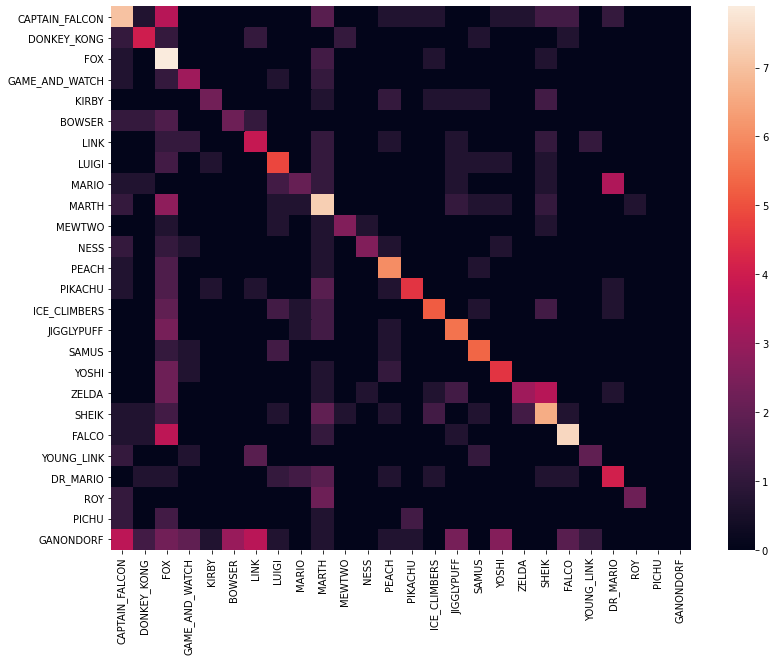

In [29]:
# sn.heatmap(conf_df, annot=False, mask=conf_df <= 0, cmap='viridis')
fig, ax = plt.subplots(figsize=(13,10))
sn.heatmap(np.log(1 + conf_df), annot=False, ax=ax, square=False)
fig.savefig('../images/confusion_matrix.png')

# Training

In [14]:
# skip first 100k clips and save them as test data
data_train = data_generator(input_directory='../data/train',
                            batch_size = 32,
                            shuffle=True,
                            repeat=True)

In [15]:
# custom_mk2
model.fit(data_train,
          epochs=10,
          steps_per_epoch=1000,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/10
1000/1000 [==============================] - 672s 672ms/step - loss: 0.3083 - accuracy: 0.5659 - top 8 accuracy: 0.8961
Epoch 2/10
1000/1000 [==============================] - 668s 668ms/step - loss: 0.1771 - accuracy: 0.7512 - top 8 accuracy: 0.9465
Epoch 3/10
1000/1000 [==============================] - 666s 666ms/step - loss: 0.1382 - accuracy: 0.8043 - top 8 accuracy: 0.9562
Epoch 4/10
1000/1000 [==============================] - 665s 665ms/step - loss: 0.1108 - accuracy: 0.8418 - top 8 accuracy: 0.9645
Epoch 5/10
1000/1000 [==============================] - 665s 665ms/step - loss: 0.0985 - accuracy: 0.8575 - top 8 accuracy: 0.9686
Epoch 6/10
1000/1000 [==============================] - 662s 662ms/step - loss: 0.0897 - accuracy: 0.8690 - top 8 accuracy: 0.9708
Epoch 7/10
1000/1000 [==============================] - 662s 662ms/step - loss: 0.0814 - accuracy: 0.8801 - top 8 accuracy: 0.9706
Epoch 8/10
1000/1000 [==============================] - 665s 665ms/step - loss: 0.0

In [16]:
# skip first 100k clips and save them as test data
data_train = data_generator(input_directory='../data/train',
                            batch_size = 64,
                            shuffle=True,
                            repeat=True)

In [17]:
# custom_mk2
model.fit(data_train,
          epochs=10,
          steps_per_epoch=500,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/10
500/500 [==============================] - 679s 1s/step - loss: 0.0588 - accuracy: 0.9094 - top 8 accuracy: 0.9762
Epoch 2/10
500/500 [==============================] - 677s 1s/step - loss: 0.0563 - accuracy: 0.9114 - top 8 accuracy: 0.9762
Epoch 3/10
500/500 [==============================] - 676s 1s/step - loss: 0.0567 - accuracy: 0.9106 - top 8 accuracy: 0.9769
Epoch 4/10
500/500 [==============================] - 676s 1s/step - loss: 0.0526 - accuracy: 0.9162 - top 8 accuracy: 0.9772
Epoch 5/10
500/500 [==============================] - 676s 1s/step - loss: 0.0513 - accuracy: 0.9182 - top 8 accuracy: 0.9767
Epoch 6/10
500/500 [==============================] - 677s 1s/step - loss: 0.0498 - accuracy: 0.9195 - top 8 accuracy: 0.9777
Epoch 7/10
500/500 [==============================] - 676s 1s/step - loss: 0.0514 - accuracy: 0.9171 - top 8 accuracy: 0.9764
Epoch 8/10
500/500 [==============================] - 677s 1s/step - loss: 0.0484 - accuracy: 0.9214 - top 8 accuracy:

In [18]:
# skip first 100k clips and save them as test data
data_train = data_generator(input_directory='../data/train',
                            batch_size = 128,
                            shuffle=True,
                            repeat=True)

In [19]:
# custom_mk2
model.fit(data_train,
          epochs=5,
          steps_per_epoch=500,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/5
500/500 [==============================] - 1366s 3s/step - loss: 0.0421 - accuracy: 0.9298 - top 8 accuracy: 0.9800
Epoch 2/5
500/500 [==============================] - 1381s 3s/step - loss: 0.0408 - accuracy: 0.9306 - top 8 accuracy: 0.9781
Epoch 3/5
500/500 [==============================] - 1384s 3s/step - loss: 0.0401 - accuracy: 0.9319 - top 8 accuracy: 0.9792
Epoch 4/5
500/500 [==============================] - 1382s 3s/step - loss: 0.0380 - accuracy: 0.9344 - top 8 accuracy: 0.9800
Epoch 5/5
500/500 [==============================] - 1366s 3s/step - loss: 0.0380 - accuracy: 0.9329 - top 8 accuracy: 0.9778

Test score: 0.035
Test accuracy: 94%
Test test top 8 accuracy: 98%


In [20]:
# skip first 100k clips and save them as test data
data_train = data_generator(input_directory='../data/train',
                            batch_size = 256,
                            shuffle=True,
                            repeat=True)

In [21]:
# custom_mk2
model.fit(data_train,
          epochs=5,
          steps_per_epoch=150,
          verbose=1)

score = model.evaluate(data_train, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/5
150/150 [==============================] - 838s 6s/step - loss: 0.0329 - accuracy: 0.9414 - top 8 accuracy: 0.9807
Epoch 2/5
150/150 [==============================] - 837s 6s/step - loss: 0.0336 - accuracy: 0.9402 - top 8 accuracy: 0.9809
Epoch 3/5
150/150 [==============================] - 837s 6s/step - loss: 0.0327 - accuracy: 0.9412 - top 8 accuracy: 0.9800
Epoch 4/5
150/150 [==============================] - 838s 6s/step - loss: 0.0329 - accuracy: 0.9417 - top 8 accuracy: 0.9821
Epoch 5/5
150/150 [==============================] - 836s 6s/step - loss: 0.0337 - accuracy: 0.9434 - top 8 accuracy: 0.9820

Test score: 0.03
Test accuracy: 94%
Test test top 8 accuracy: 98%


In [22]:
model.save('../models/custom_mk3')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
